In [3]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

In [4]:
# Check if we are EAGER
tf.executing_eagerly()

True

## <font color=blue>5.1. Checkpoint：变量的保存与恢复

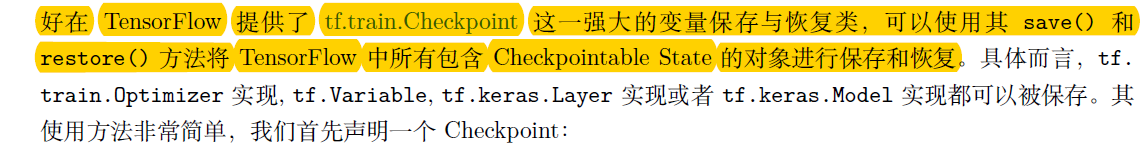

In [4]:
checkpoint = tf.train.Checkpoint(My_Model_Name = model, My_Optimizer_Name = optimizer)

NameError: name 'model' is not defined

任意取Model name 和 optimizer name。 <br><b>
在恢复变量的时候，我们还将使用这一键名。<br>
<br>
## To save the Model: <br>
当要保存时：

In [ ]:
checkpoint.save("./results/model.ckpt")

## **To restore the Model**<br>
Remember the model name should be the same as My_Model_Name in tf.train.Checkpoint(**My_Model_Name** = model)

In [ ]:
the_model_to_be_restored = Model()
checkpoint = tf.train.Checkpoint(My_Model_Name = the_model_to_be_restored)
# Restore
checkpoint.restore("./results/model.ckpt-xxxx")  # model.ckpt-xxxx: the index of the model 

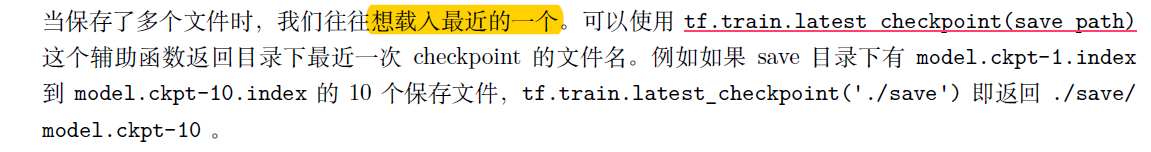

## Example in Train.py

In [ ]:
# In Train.py
model = Model()
checkpoint = tf.train.Checkpoint(the_name_of_my_model = model, the_name_of_my_opt = ...) 
# 实例化Checkpoint，指定保存对象为model（如果需要保存Optimizer 的参数也可加入）

# Your Training Code
# ............
# Your Training Code

checkpoint.save('./save/model.ckpt') # 模型训练完毕后将参数保存到文件，也可以在模型训练过程中每隔一段时间就保存一次

## Example in Test.py

In [ ]:
# In Test.py
model = Model()
checkpoint = tf.train.Checkpoint(the_name_of_my_model = model, the_name_of_my_opt = ...)
# Restore
checkpoint.restore(tf.train.latest_checkpoint('./save')) # Use the last ckpt in "./save"


# Your Test Code
# ..........
# Your Test Code

## An full Example

In [ ]:
import tensorflow as tf
import numpy as np
from your_model.mlp import MLP
from your_model.utils import DataLoader

tf.enable_eager_execution()
mode = 'test'
num_batches = 1000
batch_size = 50
learning_rate = 0.001
data_loader = DataLoader()


def train():
    model = MLP()
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    checkpoint = tf.train.Checkpoint(the_name_of_my_model = model, the_name_of_my_opt = optimizer) 
    # Instantiate the Checkpoint
    # 实例化Checkpoint，设置保存对象为model
    
    for batch_index in range(num_batches):
        X, y = data_loader(batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(tf.convert_to_tensor(X))
            loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_pred)
            print("batch %d: loss %f" % (batch_index, loss.numpy()))
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradient(grads_and_vars=zip(grads, model.variables))
        
        if (batch_index + 1) % 100 == 0:          # 每隔100 个Batch 保存一次
            checkpoint.save('./save/model.ckpt')  # 保存模型参数到文件


def test():
    
    model_to_be_restored = MLP()
    # 实例化Checkpoint，设置恢复对象为新建立的模型model_to_be_restored
    checkpoint = tf.train.Checkpoint(the_name_of_my_model=model_to_be_restored) 
    checkpoint.restore(tf.train.latest_checkpoint('./save'))  # 从文件恢复模型参数
    
    num_eval_samples = np.shape(data_loader.eval_labels)[0]
    y_pred = model_to_be_restored.predict(tf.constant(data_loader.eval_data)).numpy()
    print("test accuracy: %f" % (sum(y_pred == data_loader.eval_labels) / num_eval_samples))

    

if __name__ == '__main__':
    if mode == 'train':
        train()
    if mode == 'test':
        test()



先 mode = 'train', run 一次。<br>
再将第7 行改为mode = 'test' 并再次运行代码，

Done！

## <font color=blue>5.2 TensorBoard：训练过程可视化

目前，Eager Execution 模式下的TensorBoard 支持尚在tf.contrib.summary 内，可能以后会有较多变化，因
此这里只做简单示例。

首先,在代码目录下**建立一个文件夹（如./tensorboard）**存放TensorBoard 的记录文件，并在代码中**实例化一个记录器:**


In [5]:
summary_writer = tf.contrib.summary.create_file_writer('./tensorboard')

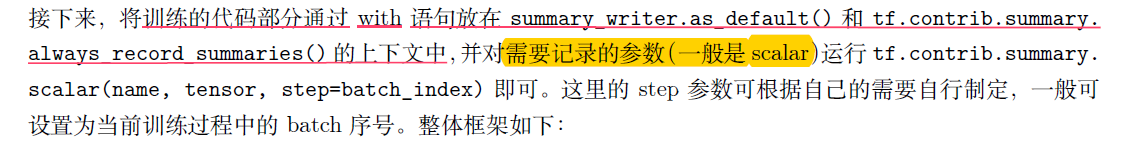

In [ ]:
with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
    
    # Starting Training Model
    for batch_index in range(num_batches):
        
        # Training 训练代码，当前batch 的损失值放入变量loss 中
        # ....... y_pred = model(X)
        # ....... loss = tf.losses.sparse....
        # Training
        
        tf.contrib.summary.scaler('loss', loss, step=batch_index)
        tf.contrib.summary.scaler('My_Scaler', my_scaler, step=batch_index) # 还可以添加其他自定义的变量来记录， 例如特别的Variable等等
    
        

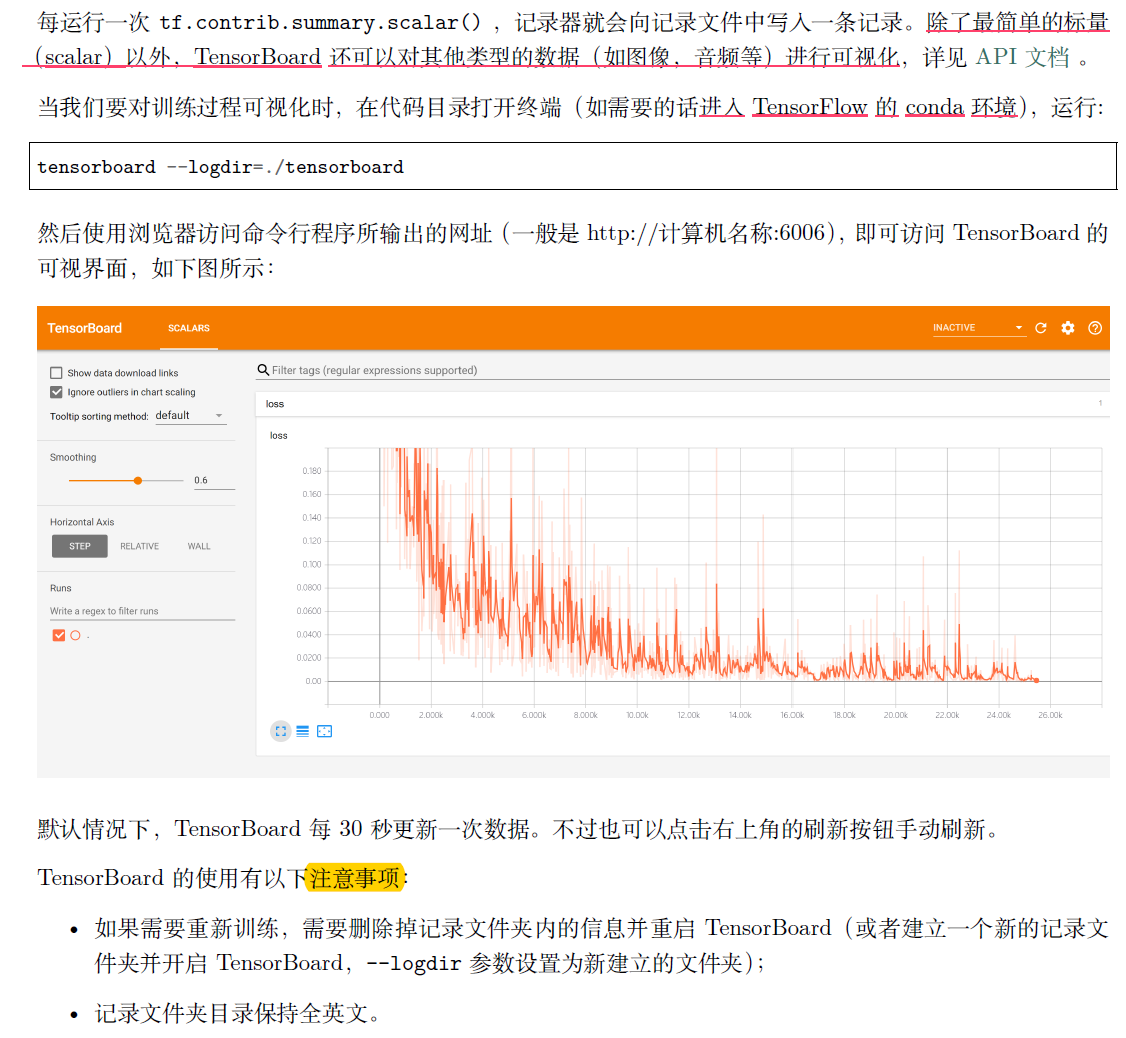

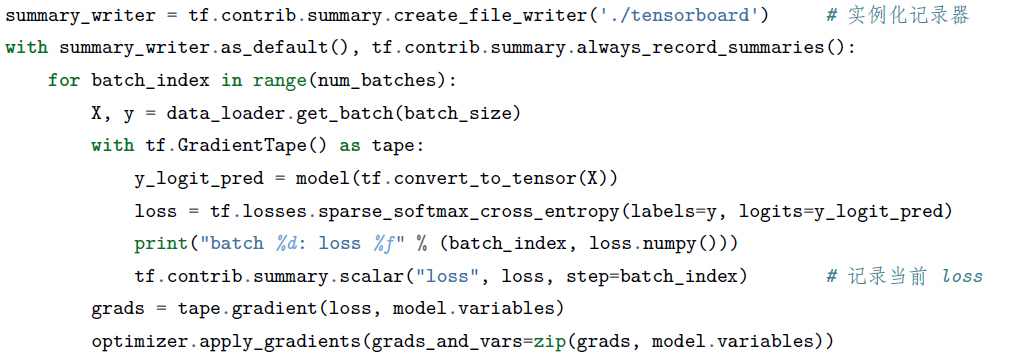

## <font color=blue>5.3 GPU 的使用与分配

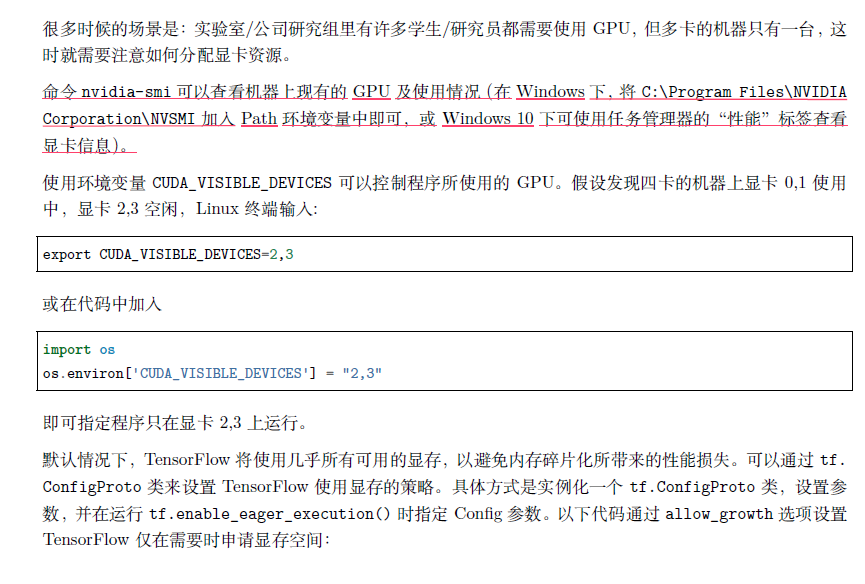

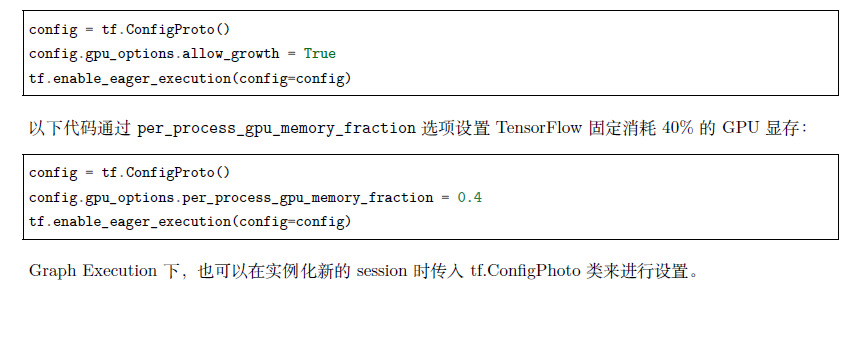